title: "organoid_gwas_genesig"
author: "Fallon Ratner"
date: '2024-01-26'

## Setting Up

- Load libraries
- Load different dataframes:
  - Fetal Cell Type Expression data from Zhong et al.,2018
  - SCZ GWAS Mapped Genes
  - Differentially Expressed Genes (DEGs) from Sawada et al., 2020 & Notaras et al., 2022

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib_venn import venn2
from matplotlib_venn import venn3
import matplotlib.pyplot as plt

#select relevant working directory
os.chdir("C:/Users/fallo/OneDrive/Documents/URF_2023/Datasets")

fetal_cells = pd.read_csv("zhong_exp_sig_cells.csv")
gwas = pd.read_csv("SCZ_GWAS_mapped_genes.txt", sep='\t')

notaras_deg = pd.read_csv("notaras_deg_condition.csv")
#skip first row 
sawada_deg = pd.read_csv("sawada_deg_condition.csv", skiprows = 1)

## Visualize Overlap of DEGs from Different SCZ Organoid Papers

- DEGs are based on the author's computational methods
- DEGS are computed based on the disease condition
- Sawada et al. uses disconcordant twin iPSCs to generate cerebral organoids
- Notaras et al. uses non-related iPSC lines from 3 SCZ and 4 Ctrl to generate forebrain organoids

In [2]:
#Sawada selection criteria: log2FC > 0.585 and FDR < 0.01
#Apply this criteria to Notaras DEGs
#Convert logFC to log2FC
notaras_deg['Log2FC'] = np.log2(np.exp(notaras_deg['logFC']))

#subset_notaras_deg <- notaras_deg[notaras_deg$log2FC > 0.585 & notaras_deg$FDR < 0.01, ]
# no genes from notaras meet this critera so changing the FDR threshold to 0.1
subset_notaras_deg = notaras_deg[(notaras_deg['Log2FC'] > 0.585) & (notaras_deg['FDR'] < 0.1)]

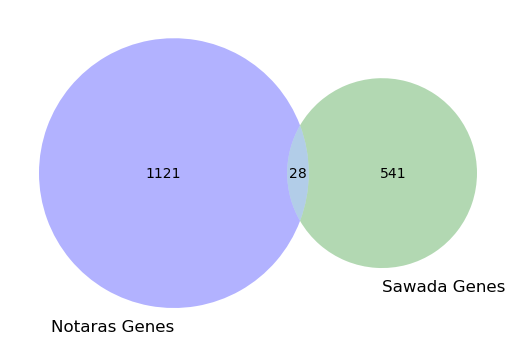

In [3]:
notaras_genes = subset_notaras_deg['Gene_name']
sawada_genes = sawada_deg['Gene_name']

notaras_genes_set = set(notaras_genes)
sawada_genes_set = set(sawada_genes)

# Create a Venn diagram
venn_diagram = venn2([notaras_genes_set, sawada_genes_set], 
                     set_labels=('Notaras Genes', 'Sawada Genes'),
                     set_colors=('blue', 'green'), alpha=0.3)



## Visualize Common SCZ Organoid Genes in a Heatmap

C:\Users\fallo\AppData\Local\Temp\ipykernel_18328\870966943.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_genes_data['Log2FC_notaras'] = pd.to_numeric(common_genes_data['Log2FC_notaras'])
C:\Users\fallo\AppData\Local\Temp\ipykernel_18328\870966943.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  common_genes_data['Log2FC_sawada'] = pd.to_numeric(common_genes_data['Log2FC_sawada'])


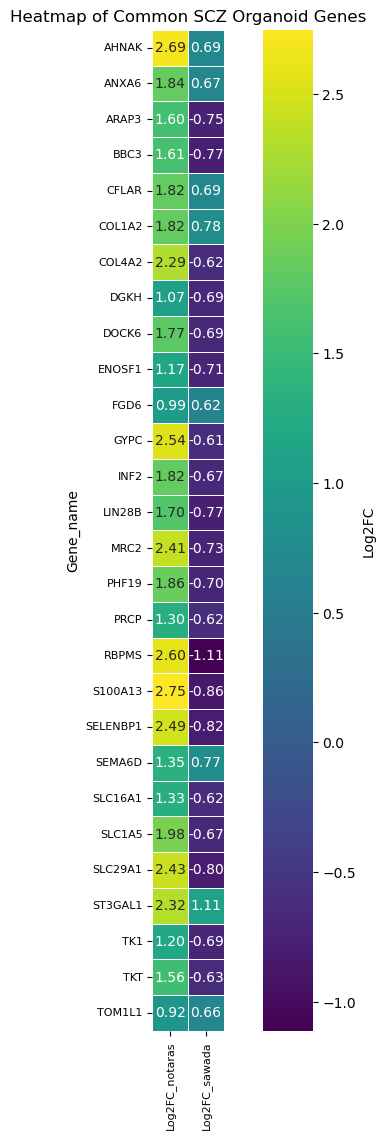

In [4]:
# Merge dataframes to find common genes
common_genes = pd.merge(subset_notaras_deg, sawada_deg, on="Gene_name")

# Rename columns
common_genes['Log2FC_notaras'] = common_genes['Log2FC_x']
common_genes['Log2FC_sawada'] = common_genes['Log2FC_y']

# Extract common genes and relevant columns for heatmap
common_genes_data = common_genes[['Gene_name', 'Log2FC_notaras', 'Log2FC_sawada']]

# Convert 'Log2FC_notaras' and 'Log2FC_sawada' to numeric
common_genes_data['Log2FC_notaras'] = pd.to_numeric(common_genes_data['Log2FC_notaras'])
common_genes_data['Log2FC_sawada'] = pd.to_numeric(common_genes_data['Log2FC_sawada'])

# Set 'Gene_name' as index
common_genes_data.set_index('Gene_name', inplace=True)

# Set the size of the plotting device
plt.figure(figsize=(10, 13))

# Create a heatmap using seaborn
sns.heatmap(common_genes_data, cmap='viridis', annot=True, fmt=".2f", linewidths=.5, cbar_kws={'label': 'Log2FC'}, square=True)

# Add title
plt.title("Heatmap of Common SCZ Organoid Genes")

# Adjust fontsize of row and column labels
plt.yticks(fontsize=8)
plt.xticks(fontsize=8)

# Show plot
plt.show()

## Visualize Overlap of Genes from SCZ Organoids and SCZ GWAS

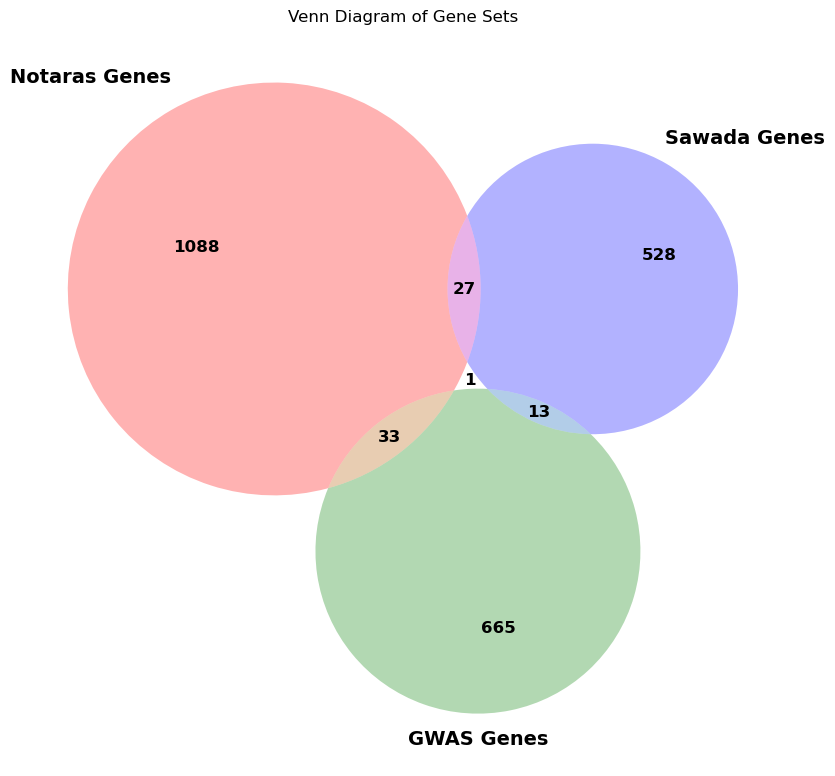

In [5]:
# Set Gene_name column in gwas DataFrame
gwas['Gene_name'] = gwas['symbol']

# Define the gene sets
notaras_genes = set(subset_notaras_deg['Gene_name'])
sawada_genes = set(sawada_deg['Gene_name'])
gwas_genes = set(gwas['Gene_name'])

# Create a list of gene sets
gene_sets = {'Notaras Genes': notaras_genes,
             'Sawada Genes': sawada_genes,
             'GWAS Genes': gwas_genes}

# Set the plot size
plt.figure(figsize=(10, 12))
# Create Venn diagram
venn_diagram = venn3(subsets=(len(gene_sets['Notaras Genes'] - gene_sets['Sawada Genes'] - gene_sets['GWAS Genes']),
                               len(gene_sets['Sawada Genes'] - gene_sets['Notaras Genes'] - gene_sets['GWAS Genes']),
                               len(gene_sets['Sawada Genes'] & gene_sets['Notaras Genes'] - gene_sets['GWAS Genes']),
                               len(gene_sets['GWAS Genes'] - gene_sets['Sawada Genes'] - gene_sets['Notaras Genes']),
                               len(gene_sets['GWAS Genes'] & gene_sets['Notaras Genes'] - gene_sets['Sawada Genes']),
                               len(gene_sets['GWAS Genes'] & gene_sets['Sawada Genes'] - gene_sets['Notaras Genes']),
                               len(gene_sets['GWAS Genes'] & gene_sets['Sawada Genes'] & gene_sets['Notaras Genes'])),
                     set_labels=('Notaras Genes', 'Sawada Genes', 'GWAS Genes'),
                     set_colors=('red', 'blue', 'green'), alpha=0.3)

# Adjust text properties
for text in venn_diagram.set_labels:
    text.set_fontsize(14)
    text.set_fontweight('bold')

for text in venn_diagram.subset_labels:
    text.set_fontsize(12)
    text.set_fontweight('bold')

# Display the plot
plt.title("Venn Diagram of Gene Sets")
plt.show()

## Visualize Common SCZ Organoid & GWAS Genes in a Heatmap

In [6]:
# Find the overlapping genes between notaras, sawada, and gwas
overlap_genes = set(notaras_genes) & set(sawada_genes) & set(gwas_genes)

# Find the overlapping genes between notaras and gwas
overlap_genes2 = set(notaras_genes) & set(gwas_genes)

# Find the overlapping genes between sawada and gwas
overlap_genes3 = set(sawada_genes) & set(gwas_genes)

# Create dataframes with the overlapping genes and the corresponding datasets
overlap_df = pd.DataFrame({'Gene_name': list(overlap_genes), 'Notaras': 'Yes', 'Sawada': 'Yes', 'GWAS': 'Yes'})
overlap_df2 = pd.DataFrame({'Gene_name': list(overlap_genes2), 'Notaras': 'Yes', 'Sawada': 'No', 'GWAS': 'Yes'})
overlap_df3 = pd.DataFrame({'Gene_name': list(overlap_genes3), 'Notaras': 'No', 'Sawada': 'Yes', 'GWAS': 'Yes'})

# Combine all dataframes into one
all_overlap_df = pd.concat([overlap_df, overlap_df2, overlap_df3], ignore_index=True)

# Display the resulting table
print(all_overlap_df)

    Gene_name Notaras Sawada GWAS
0         TKT     Yes    Yes  Yes
1      TRANK1     Yes     No  Yes
2        ECM1     Yes     No  Yes
3        RRAS     Yes     No  Yes
4        PCCB     Yes     No  Yes
5        TWF2     Yes     No  Yes
6        DGKZ     Yes     No  Yes
7       ALDOA     Yes     No  Yes
8       PRR13     Yes     No  Yes
9       PLCB2     Yes     No  Yes
10      SMIM4     Yes     No  Yes
11       SNX8     Yes     No  Yes
12       PMM1     Yes     No  Yes
13    CCDC134     Yes     No  Yes
14       CLTA     Yes     No  Yes
15      SERF2     Yes     No  Yes
16    ARL6IP4     Yes     No  Yes
17    GALNT10     Yes     No  Yes
18     PRSS16     Yes     No  Yes
19      COX5B     Yes     No  Yes
20      PRKCD     Yes     No  Yes
21      FURIN     Yes     No  Yes
22      PEX16     Yes     No  Yes
23    SPATS2L     Yes     No  Yes
24  HIST1H2BN     Yes     No  Yes
25     GLYCTK     Yes     No  Yes
26     NT5DC2     Yes     No  Yes
27      SHMT2     Yes     No  Yes
28      RPS17 

## Visualize Overlap of Genes from SCZ Organoids and Fetal Brain

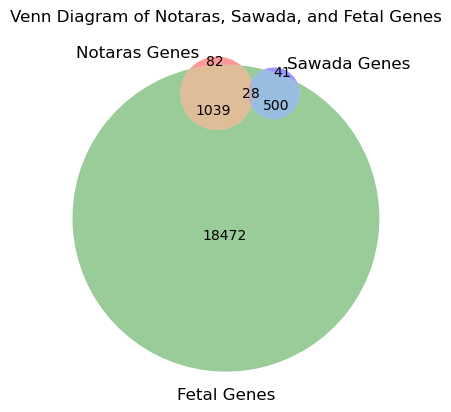

In [8]:
# Rename column
fetal_cells['Gene_name'] = fetal_cells['SYMBOL']

# Extract gene names from the data frames
notaras_genes = set(subset_notaras_deg['Gene_name'])
sawada_genes = set(sawada_deg['Gene_name'])
fetal_genes = set(fetal_cells['Gene_name'].dropna())

# Create a list of gene sets
venn_sets = {'Notaras Genes': notaras_genes, 'Sawada Genes': sawada_genes, 'Fetal Genes': fetal_genes}

# Create Venn diagram
venn = venn3(subsets=venn_sets.values(), set_labels=venn_sets.keys(), set_colors=('red', 'blue', 'green'))

plt.title("Venn Diagram of Notaras, Sawada, and Fetal Genes")

# Show plot
plt.show()

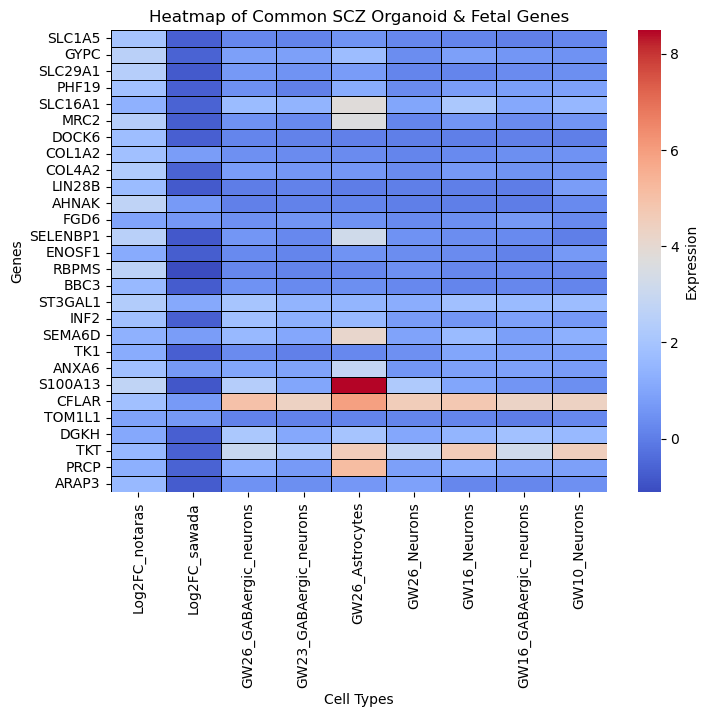

In [9]:
# Find the overlapping genes between notaras, sawada, and fetal genes
common_genes = list(set(notaras_genes) & set(sawada_genes) & set(fetal_genes))

# Create a dataframe with the overlapping genes
common_df = pd.DataFrame({'Gene_name': common_genes})

# Merge with 'notaras_deg' and add the "Log2FC" column
common_df = pd.merge(common_df, subset_notaras_deg[['Gene_name', 'Log2FC']], on='Gene_name', how='left')

# Merge with 'sawada_deg' and add the "Log2FC" column
common_df = pd.merge(common_df, sawada_deg[['Gene_name', 'Log2FC']], on='Gene_name', how='left')
# Rename columns
common_df.rename(columns={'Log2FC_x': 'Log2FC_notaras', 'Log2FC_y': 'Log2FC_sawada'}, inplace=True)

# Merge with gene expression data from 'fetal_cells'
common_df = pd.merge(common_df, fetal_cells, on='Gene_name', how='left')

# Extract relevant columns for heatmap
subset_common_df = common_df[['Gene_name', 'Log2FC_notaras', 'Log2FC_sawada', 'GW26_GABAergic_neurons', 
                              'GW23_GABAergic_neurons', 'GW26_Astrocytes', 'GW26_Neurons', 'GW16_Neurons',
                              'GW16_GABAergic_neurons', 'GW10_Neurons']]
# Set 'Gene_name' as row names
subset_common_df.set_index('Gene_name', inplace=True)

# Set the size of the plotting device
plt.figure(figsize=(8, 6))

# Create a heatmap using seaborn
sns.heatmap(subset_common_df, cmap='coolwarm', linewidths=0.5, linecolor='black', cbar_kws={'label': 'Expression'})
plt.title('Heatmap of Common SCZ Organoid & Fetal Genes')
plt.xlabel('Cell Types')
plt.ylabel('Genes')

# Show plot
plt.show()

## Correlate Common Genes in SCZ Organoids with Fetal Cell Types

Log2FC                    1.000000
GW26_GABAergic_neurons   -0.378375
GW23_GABAergic_neurons   -0.361029
GW26_Astrocytes          -0.414890
GW26_Neurons             -0.362602
GW16_Neurons             -0.407599
GW16_GABAergic_neurons   -0.386897
GW10_Neurons             -0.401682
dtype: float64


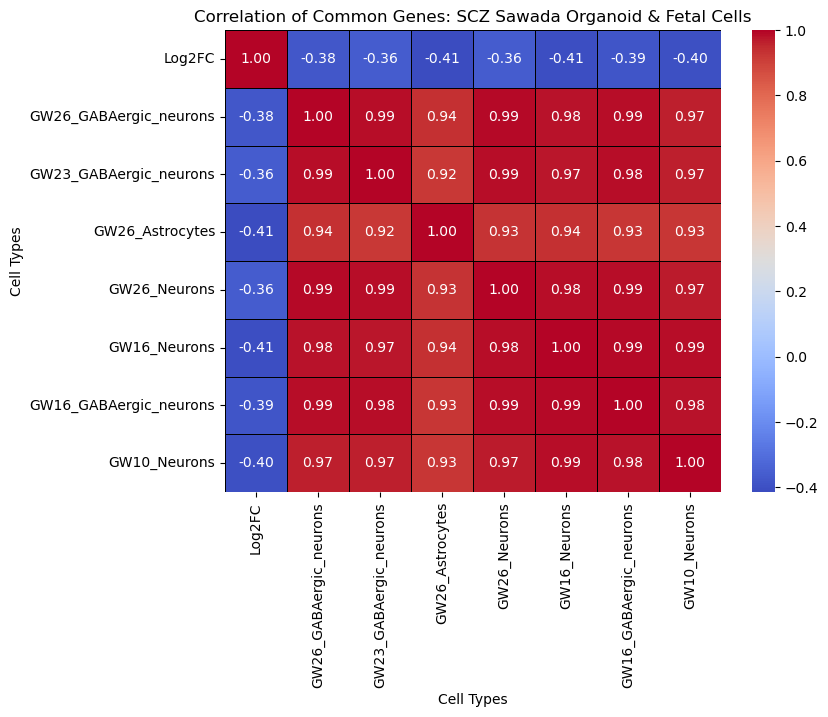

In [10]:
# Find the overlapping genes between notaras and fetal genes
common_genes2 = list(set(notaras_genes) & set(fetal_genes))

# Subset common genes from 'fetal_cells'
common_genes_fetal_cells = fetal_cells[fetal_cells['Gene_name'].isin(common_genes2)]
# Subset 'subset_notaras_deg' based on common genes
subset_notaras_common = subset_notaras_deg[subset_notaras_deg['Gene_name'].isin(common_genes2)]
# Extract relevant columns for correlation
common_genes_notaras = subset_notaras_common[['Gene_name', 'Log2FC']]
common_genes_fetal_cells_subset = common_genes_fetal_cells[['Gene_name', 'GW26_GABAergic_neurons', 'GW23_GABAergic_neurons', 
                                                             'GW26_Astrocytes', 'GW26_Neurons', 'GW16_Neurons', 
                                                             'GW16_GABAergic_neurons', 'GW10_Neurons']]

# Merge the two dataframes on 'Gene_name'
merged_data = pd.merge(common_genes_notaras, common_genes_fetal_cells_subset, on='Gene_name', how='left')

# Convert 'Log2FC' to numeric
merged_data['Log2FC'] = pd.to_numeric(merged_data['Log2FC'], errors='coerce')

# Extract the Log2FC column from the merged data
log2fc_column = merged_data['Log2FC']

# Compute correlation for each cell type
correlations = merged_data.drop(columns=['Gene_name']).apply(lambda x: np.corrcoef(log2fc_column, x, rowvar=False)[0, 1], axis=0)

# Display or further analyze the correlation results
print(correlations)

# Extract the numeric data for correlation matrix
cor_matrix = merged_data.drop(columns=['Gene_name']).corr()

# Set the size of the plotting device
plt.figure(figsize=(8, 6))

# Create a heatmap using seaborn
sns.heatmap(cor_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5, linecolor='black')
plt.title('Correlation of Common Genes: SCZ Sawada Organoid & Fetal Cells')
plt.xlabel('Cell Types')
plt.ylabel('Cell Types')

# Show plot
plt.show()

# Find the overlapping genes between sawada and fetal genes

Log2FC                    1.000000
GW26_GABAergic_neurons    0.232616
GW23_GABAergic_neurons    0.246076
GW26_Astrocytes           0.030312
GW26_Neurons              0.181323
GW16_Neurons              0.157110
GW16_GABAergic_neurons    0.185680
GW10_Neurons              0.169892
dtype: float64


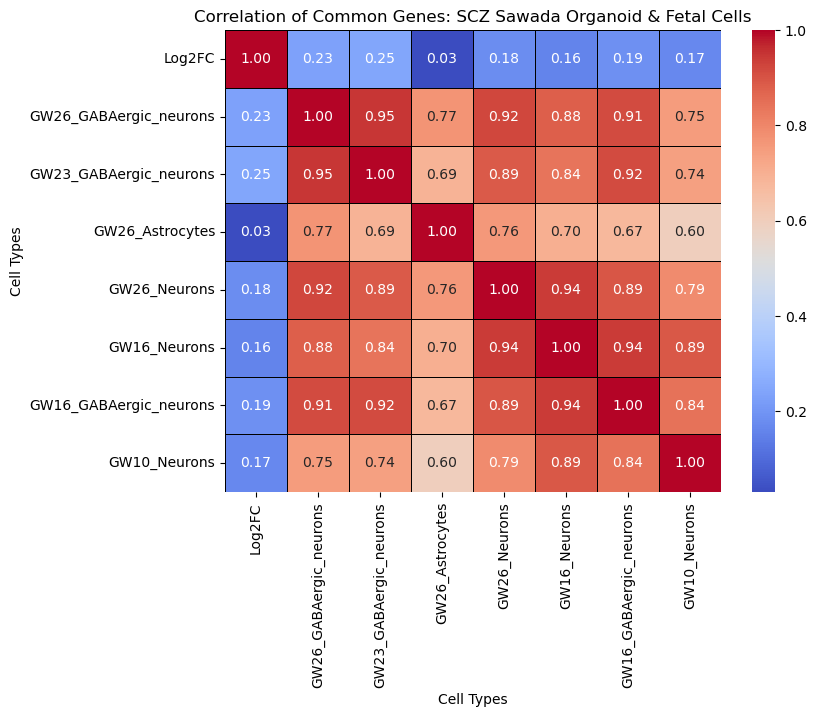

In [11]:
common_genes3 = list(set(sawada_genes) & set(fetal_genes))

# Subset common genes from 'fetal_cells'
common_genes_fetal_cells = fetal_cells[fetal_cells['Gene_name'].isin(common_genes3)]
# Subset 'sawada_deg' based on common genes
subset_sawada_common = sawada_deg[sawada_deg['Gene_name'].isin(common_genes3)]
# Extract relevant columns for correlation
common_genes_sawada = subset_sawada_common[['Gene_name', 'Log2FC']]
common_genes_fetal_cells_subset = common_genes_fetal_cells[['Gene_name', 'GW26_GABAergic_neurons', 'GW23_GABAergic_neurons', 
                                                             'GW26_Astrocytes', 'GW26_Neurons', 'GW16_Neurons', 
                                                             'GW16_GABAergic_neurons', 'GW10_Neurons']]

# Merge the two dataframes on 'Gene_name'
merged_data = pd.merge(common_genes_sawada, common_genes_fetal_cells_subset, on='Gene_name', how='left')

# Convert 'Log2FC' to numeric
merged_data['Log2FC'] = pd.to_numeric(merged_data['Log2FC'], errors='coerce')

# Extract the Log2FC column from the merged data
log2fc_column = merged_data['Log2FC']

# Select only numeric columns (excluding 'Gene_name') for correlation
numeric_cols = merged_data.select_dtypes(include=np.number).columns

# Compute correlation for each cell type
correlations = merged_data[numeric_cols].apply(lambda x: np.corrcoef(log2fc_column, x, rowvar=False)[0, 1], axis=0)

# Display or further analyze the correlation results
print(correlations)

# Extract the numeric data for correlation matrix
cor_matrix = merged_data[numeric_cols].corr()

# Set the size of the plotting device
plt.figure(figsize=(8, 6))

# Create a heatmap using seaborn
sns.heatmap(cor_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5, linecolor='black')
plt.title('Correlation of Common Genes: SCZ Sawada Organoid & Fetal Cells')
plt.xlabel('Cell Types')
plt.ylabel('Cell Types')

# Show plot
plt.show()